In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import median_abs_deviation

In [2]:
def preprocess(df, humanCheck = False):
    listIntToBool = ['AU7', 'AU20', 'looking_away']
    for col in listIntToBool:
        df[col] = df[col].astype('bool')
        
    listBB = ['FaceRectX', 'FaceRectY', 'FaceRectWidth', 'FaceRectHeight']
    listLandmarks = ['x' + str(i) for i in range(68)] + ['y' + str(i) for i in range(68)]
    listTime = ['Timestamp']
    
    listAUDiff = ['AU1_diff','AU2_diff','AU4_diff','AU5_diff','AU6_diff','AU7_diff','AU9_diff','AU10_diff','AU11_diff','AU12_diff',
                'AU14_diff','AU15_diff','AU17_diff','AU20_diff','AU23_diff','AU24_diff','AU25_diff','AU26_diff','AU28_diff','AU43_diff']
    listEmoDiff = ['disgust_diff','fear_diff','happiness_diff', 'anger_diff', 'sadness_diff','surprise_diff','neutral_diff','emotion_mirroring_diff']
    
    listEyes = ['eyeWidth', 'eyeHeight', 'mean_EAR', 'mean_pupil_ratio']
    
    listAU = ['AU1','AU2','AU4','AU5','AU6','AU7','AU9','AU10','AU11',
              'AU12','AU14','AU15','AU17','AU20','AU23','AU24','AU25','AU26','AU28','AU43']
    
    listFaceDirection = ['Pitch', 'Yaw', 'Roll']
    
    featureTest = ['AU5', 'AU10', 'AU15', 'AU26', 'AU28', 'looking_away', 'AU1_diff', 'AU2_diff', 'AU4_diff', 'AU5_diff', 'AU6_diff', 'AU7_diff', 'AU9_diff', 'AU10_diff', 
                   'AU11_diff', 'AU12_diff', 'AU14_diff', 'AU15_diff', 'AU17_diff', 'AU20_diff', 'AU23_diff', 'AU24_diff', 'AU25_diff', 'AU26_diff', 'AU28_diff', 
                   'AU43_diff', 'anger_diff', 'disgust_diff', 'fear_diff', 'happiness_diff', 'surprise_diff', 'neutral_diff', 'emotion_mirroring_diff']
    ##      + listEmoDiff 
    
    
    totalcolumns = listBB + listLandmarks + listTime  + listEyes + featureTest# + listFaceDirection
        
    df = df.drop(columns = totalcolumns)
    df = df.drop(columns=['pupil_direction', 'Person'])
    df = df[df['Label'] != 'x']
    df = df[df['Label'] != 'skip']
    df['Label'] = df['Label'].replace({'n': 0, 'no': 0, 'y': 1, 'yes': 1})
    if humanCheck:
        df['liridonLabels'] = df['liridonLabels'].replace({'n': 0, 'no': 0, 'y': 1, 'yes': 1})
        df['elenaLabels'] = df['elenaLabels'].replace({'n': 0, 'no': 0, 'y': 1, 'yes': 1})
        df['sunnyLabels'] = df['sunnyLabels'].replace({'n': 0, 'no': 0, 'y': 1, 'yes': 1})
    return df

def generate_chunk_summary(chunk, global_statistics={}, fullList=[], meanSDList=[], humanCheck = False):
    chunk_df = pd.DataFrame(chunk)
    chunk_summary = chunk_df.mean().to_dict()  # calculate mean for all columns\n",
    for col in fullList:  # calculate quartiles and standard deviation for columns in fullList\n",
        chunk_summary.update({
            f'{col}_mean': chunk_df[col].mean(),
            f'{col}_Q1': chunk_df[col].quantile(0.25),
            f'{col}_Q2': chunk_df[col].median(),
            f'{col}_Q3': chunk_df[col].quantile(0.75),
            f'{col}_SD': chunk_df[col].std(),
            f'{col}_MAD': median_abs_deviation(chunk_df[col])
        })
    for col in meanSDList:  # calculate quartiles and standard deviation for columns in fullList\n",
        chunk_summary.update({
            f'{col}_mean': chunk_df[col].mean(),
            f'{col}_SD': chunk_df[col].std(),
        })    
    chunk_summary['Label'] = chunk_df['Label'].values[-1]
    if humanCheck:
        chunk_summary['liridonLabels'] = chunk_df['liridonLabels'].values[-1]
        chunk_summary['elenaLabels'] = chunk_df['elenaLabels'].values[-1]
        chunk_summary['sunnyLabels'] = chunk_df['sunnyLabels'].values[-1]
    return chunk_summary

# def generate_chunk_summary(chunk, global_statistics={},fullList=[], meanSDList=[], humanCheck=False):
#     chunk_df = pd.DataFrame(chunk)
    
#     # Calculate local statistics
#     local_summary = chunk_df.mean().to_dict()
#     local_sd = chunk_df.std().to_dict()
#     local_mad = chunk_df.mad().to_dict()
#     #local_quartiles = chunk_df.quantile([0.25, 0.5, 0.75]).to_dict()
    
#     # Compare local statistics to global statistics and calculate differences
#     for key in global_statistics['mean']:
#         local_summary[f'{key}_diff_from_global'] = local_summary[key] - global_statistics['mean'][key]
        
#     for key in global_statistics['sd']:
#         local_summary[f'{key}_sd_diff_from_global'] = local_sd[key] - global_statistics['sd'][key]
        
#     for key in global_statistics['mad']:
#         local_summary[f'{key}_mad_diff_from_global'] = local_mad[key] - global_statistics['mad'][key]
        
#     # for key in global_statistics['quartiles']:
#     #     for quartile in [0.25, 0.5, 0.75]:
#     #         local_summary[f'{key}_q{int(quartile * 100)}_diff_from_global'] = local_quartiles[key][quartile] - global_statistics['quartiles'][key][quartile]

#     local_summary['Label'] = chunk_df['Label'].values[-1]
#     if humanCheck:
#         local_summary['liridonLabels'] = chunk_df['liridonLabels'].values[-1]
#         local_summary['elenaLabels'] = chunk_df['elenaLabels'].values[-1]
#         local_summary['sunnyLabels'] = chunk_df['sunnyLabels'].values[-1]
    
#     return local_summary


def create_chunks(df, chunk_size, global_statistics={}, humanCheck = False):
    fullList = ['EAR']
    fewList = [] # 'Pitch', 'Yaw', 'Roll'
    df_new = pd.DataFrame()
    current_chunk = []
    start_of_probe = -1
    summaries = []

    for _, row in df.iterrows():
        if start_of_probe < 0 or (row['Frame'] - start_of_probe) >= 500:
            # Finalize the current chunk, if there is one
            if current_chunk:
                chunk_summary = generate_chunk_summary(current_chunk, global_statistics, fullList, fewList, humanCheck)
                summaries.append(chunk_summary)
            
            # Start a new probe and a new chunk
            start_of_probe = row['Frame']
            current_chunk = [row]
        elif len(current_chunk) == chunk_size:
            # We have a complete chunk, so finalize it
            chunk_summary = generate_chunk_summary(current_chunk, global_statistics, fullList, fewList, humanCheck)
            summaries.append(chunk_summary)
            current_chunk = [row]
        else:
            # Add the current row to the current chunk
            current_chunk.append(row)

    # Finalize the last chunk, if there is one
    if current_chunk:
        chunk_summary = generate_chunk_summary(current_chunk, global_statistics, fullList, fewList, humanCheck)
        summaries.append(chunk_summary)
    
    df_new = pd.DataFrame(summaries)
    return df_new

def preprocess_and_chunk(filename, chunk_size, cols_full=[], humanCheck = False):
    df = pd.read_csv(filename)
    
    columns_of_interest = [] # Add more columns if needed
    global_statistics = {
        'mean': {col: df[col].mean() for col in columns_of_interest},
        'sd': {col: df[col].std() for col in columns_of_interest},
        'mad': {col: df[col].mad() for col in columns_of_interest},
        'quartiles': {col: df[col].quantile([0.25, 0.5, 0.75]).to_dict() for col in columns_of_interest}
    }    
    cols_full = ['happiness']
    for col in cols_full:
        mean_full = df[col].mean()
        df[f'{col}_mean_full'] = mean_full
        df[f'{col}_mean_diff'] = df[col] - mean_full
    
    df['head_movement'] = df[['Pitch', 'Yaw', 'Roll']].diff().abs().sum(axis=1)
    df['Yaw_normalized'] = (df['Yaw'] + 90) / 180
    df['combined_gaze'] = (df['Yaw_normalized'] + df['pupil_ratio']) / 2
    df = df.drop(columns='Yaw_normalized')
    mean_value = df['EAR'].iloc[:1000].mean()
    df['calibrated_EAR'] = mean_value
    combined_gaze = df['combined_gaze'].iloc[:1000].mean()
    df['calibrated_combined_gaze'] = combined_gaze
    df['gaze_deviation_from_start'] = abs(df['combined_gaze'] - df['calibrated_combined_gaze'])
    #df['pupil_deviation'] = abs(df['mean_pupil_ratio'] - df['pupil_ratio'])
    df['EAR_deviation'] = abs(df['EAR'] - df['calibrated_EAR'])
    
    drop_columns = [f'{col}_mean_full' for col in cols_full]
    df = df.drop(columns=drop_columns)
    
    df = preprocess(df, humanCheck)

    df_chunks = create_chunks(df, chunk_size, global_statistics, humanCheck)
    df_chunks = df_chunks.drop(columns=['calibrated_EAR', 'calibrated_combined_gaze', 'EAR'])
      
    return df_chunks

def checkForFullYes(filename):
    df = pd.read_csv(filename)
    counts = df['Label'].value_counts()
    no_count = counts.get('no', 0)
    n_count = counts.get('n', 0)
    finalcount = no_count + n_count
    #print(filename, finalcount)
    return finalcount

In [3]:
kalman = False
if kalman == True:
    kalman = '_kalman'
else: kalman = ''
print(kalman)
number = 250
filenames = [f"finaldata_{number}{kalman}/{i}.csv" for i in range(1, 39)]  ## ["1.csv", "2.csv", ..., "38.csv"]

test_indices = [5, 8, 15, 17, 23, 32, 37]  ## generate test set based on index name

train_filenames = [f for i, f in enumerate(filenames, start=1) if i not in test_indices]
test_filenames = [f for i, f in enumerate(filenames, start=1) if i in test_indices]

dataframes_train = []
dataframes_test = []

chunkBool = 1
chunk_size = 25  


if chunkBool:
    for filename in train_filenames:
        finalcount = checkForFullYes(filename)
        if finalcount == 0:
            continue        
        chunked_df = preprocess_and_chunk(filename, chunk_size)
        dataframes_train.append(chunked_df)
    
    for filename in test_filenames:
        finalcount = checkForFullYes(filename)
        if finalcount == 0:
            continue          
        chunked_df = preprocess_and_chunk(filename, chunk_size)
        dataframes_test.append(chunked_df)
else:
    for filename in train_filenames:
        df = pd.read_csv(filename)
        preprocessed_df = preprocess(df)
        dataframes_train.append(preprocessed_df)

    for filename in test_filenames:
        df = pd.read_csv(filename)
        preprocessed_df = preprocess(df)
        dataframes_test.append(preprocessed_df)
    

train_combined_df = pd.concat(dataframes_train, ignore_index=True)
X_train = train_combined_df.drop(columns=['Label', 'Frame'])
y_train = train_combined_df['Label']

test_combined_df = pd.concat(dataframes_test, ignore_index=True)
X_test = test_combined_df.drop(columns=['Label', 'Frame'])
y_test = test_combined_df['Label']

In [4]:
y_test.value_counts()


# 1.00    1516
# 0.00     240

1    1096
0     207
Name: Label, dtype: int64

In [5]:
smote = SMOTE(random_state=42)


In [6]:
print(len(y_train))
print(y_train.value_counts())
## 5270, 1288

3464
1    2806
0     658
Name: Label, dtype: int64


In [7]:
X_train_filled = X_train.fillna(X_train.median())
X_test_filled = X_test.fillna(X_train.median())

In [8]:
from imblearn.under_sampling import NearMiss
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, f1_score

# Create a custom scorer
def negative_class_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, pos_label=0)  # Assuming 0 is the label for the negative class

negative_class_f1_scorer = make_scorer(negative_class_f1)


smoteBool = 0
undersampleBool = 0

#rfecv = RFECV(estimator=XGBClassifier(), step=1, cv=StratifiedKFold(5), scoring=negative_class_f1_scorer)

if smoteBool:
    print('SMOTE xgboost')
    X_train_smote, y_train_smote = smote.fit_resample(X_train_filled, y_train)
    scale_pos_weight = len(y_train_smote[y_train_smote == 0]) / len(y_train_smote[y_train_smote == 1])
    model = XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight=(scale_pos_weight), 
                              learning_rate=0.12, min_child_weight=1, max_delta_step=5,
                              n_estimators = 200)
    model.fit(X_train_smote, y_train_smote)
elif undersampleBool:
    print('UNDERSAMPLE xgboost')
    nm = NearMiss()
    X_train_filled, y_train = nm.fit_resample(X_train_filled, y_train)
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    model = make_pipeline(rfecv, XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight=scale_pos_weight))  # Adjust hyperparameters as needed
    model.fit(X_train_filled, y_train)
else:
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    print(f'REGULAR xgboost, scale_weight:{scale_pos_weight}')
    
    # model = make_pipeline(rfecv, XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight=(scale_pos_weight/3), 
    #                           learning_rate=0.12, min_child_weight=1, max_delta_step=5,
    #                           n_estimators = 200))  # Adjust hyperparameters as needed
    model = XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight=(scale_pos_weight/3), 
                              learning_rate=0.12, min_child_weight=1, max_delta_step=5,
                              n_estimators = 200)
    model.fit(X_train_filled, y_train)


REGULAR xgboost, scale_weight:0.2344975053456878


In [9]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Standardize the features
scaler = StandardScaler()
# Create a pipeline: standardize, then run SVM
svm_clf = make_pipeline(scaler, svm.SVC(kernel='rbf' ,class_weight='balanced', random_state=42, probability=1, gamma='auto', C=1))

# Fit the SVM model
if smoteBool:
    svm_clf.fit(X_train_smote, y_train_smote)
    y_pred_svm = svm_clf.predict(X_test_filled)
else:
    svm_clf.fit(X_train_filled, y_train)
    y_pred_svm = svm_clf.predict(X_test_filled)

In [10]:
print(len(X_train_filled))

y_pred = model.predict(X_test_filled)
print('--------- XGB ------------')
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

print('------------SVM-------------')
accuracy = accuracy_score(y_test, y_pred_svm)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, y_pred_svm))

y_pred_svm = svm_clf.predict(X_test_filled)

cm = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix:")
print(cm)

auroc = roc_auc_score(y_test, y_pred_svm)


print('------------XGB-PROBA--------------')
y_pred_proba = model.predict_proba(X_test_filled)[:,1]



print("AUROC SVM: %.2f" % auroc)

## 43, 60, 50 en also 92, 85 en 88 (SVM) 250
## 41, 57, 48 en also 91, 84 en 88 (SVM KALMAN) 250

## 36, 58, 44 en also 91, 80 en 85 (SVM) 500
## 38, 58, 46 en also 91, 82 en 86 (SVM Kalman) 500

## 32, 57, 41 en also 90, 77 en 83 (SVM) 750
## 34, 56, 42 en also 90, 79 en 74 (SVM Kalman) 750


## f1 of 0.82, roc-auc of 0.72


3464
--------- XGB ------------
Accuracy: 78.89%
              precision    recall  f1-score   support

           0       0.36      0.43      0.40       207
           1       0.89      0.86      0.87      1096

    accuracy                           0.79      1303
   macro avg       0.63      0.65      0.63      1303
weighted avg       0.81      0.79      0.80      1303

Confusion Matrix:
[[ 90 117]
 [158 938]]
------------SVM-------------
Accuracy: 79.97%
              precision    recall  f1-score   support

           0       0.41      0.63      0.50       207
           1       0.92      0.83      0.87      1096

    accuracy                           0.80      1303
   macro avg       0.67      0.73      0.69      1303
weighted avg       0.84      0.80      0.82      1303

Confusion Matrix:
[[131  76]
 [185 911]]
------------XGB-PROBA--------------
AUROC SVM: 0.73


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


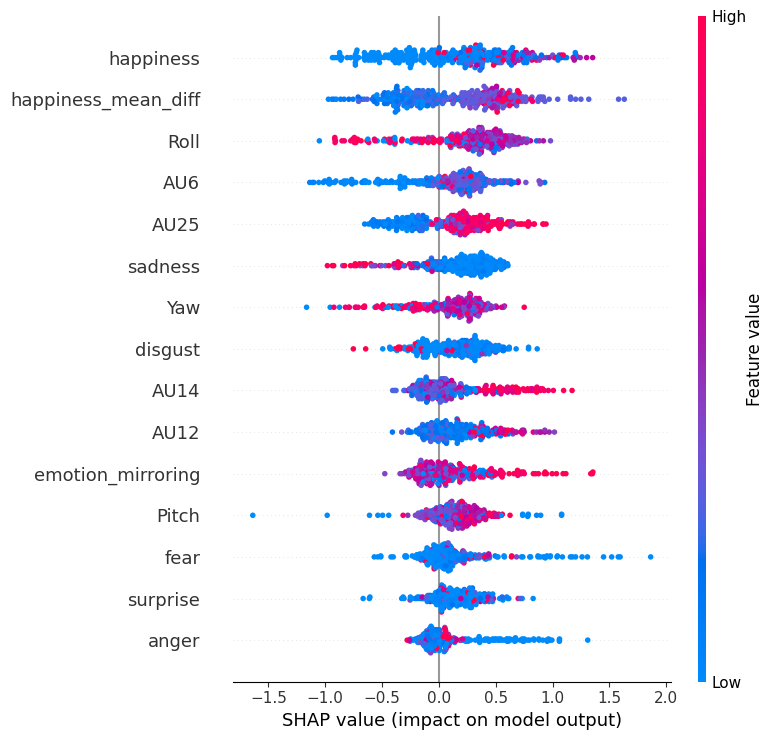

In [11]:
import shap

# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)

# Define the number of samples you want
num_samples = 350

# Calculate Shap values
if smoteBool:
    print('smote')
    sample = X_train_smote.sample(n=num_samples, random_state=42, replace=True)
    shap_values = explainer.shap_values(sample)
    shap.summary_plot(shap_values, sample)
else:
    sample = X_train_filled.sample(n=num_samples, random_state=42, replace=True)
    shap_values = explainer.shap_values(sample)
    shap.summary_plot(shap_values, sample, max_display=15)


In [12]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

X_train_smote, y_train_smote = smote.fit_resample(X_train_filled, y_train)

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train_smote, X_test_filled, y_train_smote, y_test)

# Prints the model performance
print(models)

100%|██████████| 29/29 [00:20<00:00,  1.44it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NearestCentroid                    0.66               0.75     0.75      0.70   
GaussianNB                         0.60               0.72     0.72      0.65   
BernoulliNB                        0.65               0.72     0.72      0.70   
SVC                                0.80               0.71     0.71      0.81   
RidgeClassifierCV                  0.63               0.71     0.71      0.68   
LinearDiscriminantAnalysis         0.63               0.71     0.71      0.68   
RidgeClassifier                    0.63               0.71     0.71      0.68   
LinearSVC                          0.62               0.71     0.71      0.67   
LogisticRegression                 0.62               0.71     0.71      0.67   
NuSVC                              0.79               0.70     0.70      0.81   
AdaBoostClassifier          

In [13]:
# ###Create a background dataset (you can also use a subset of your train dataset)
# background_data = X_train_filled.iloc[90:93,:]

# ###Use KernelExplainer for SVM
# explainer = shap.KernelExplainer(svm_clf.predict_proba, background_data)

# ###Calculate shap_values for all of X
# shap_values = explainer.shap_values(X_test_filled)

# ###Plot the SHAP values
# shap.summary_plot(shap_values, X_test_filled)


Accuracy: 79.97%
              precision    recall  f1-score   support

           0       0.41      0.63      0.50       207
           1       0.92      0.83      0.87      1096

    accuracy                           0.80      1303
   macro avg       0.67      0.73      0.69      1303
weighted avg       0.84      0.80      0.82      1303



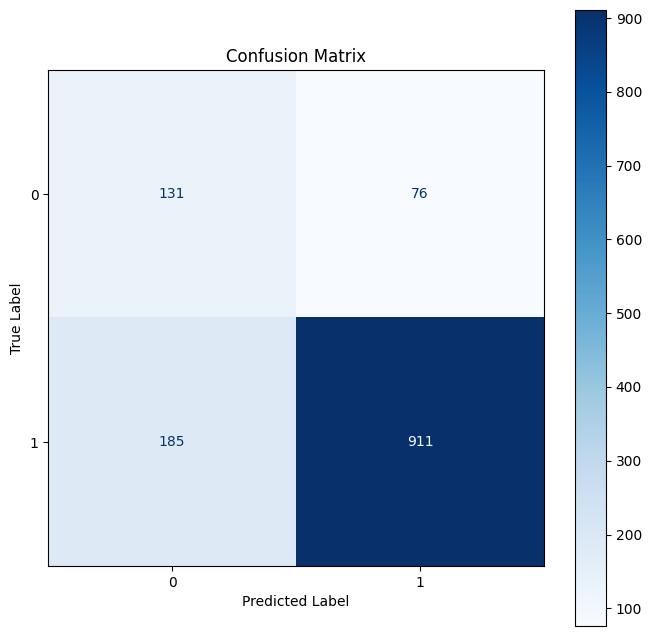

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_svm)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, y_pred_svm))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(ax=ax, cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [15]:
import numpy as np
def smooth_data(data, window_size, method='average'):
    if method == 'average':
        window = np.ones(window_size) / window_size
        smoothed_data = np.convolve(data, window, mode='same')
    elif method == 'gaussian':
        window = np.hanning(window_size)
        window /= window.sum()
        smoothed_data = np.convolve(data, window, mode='same')
    else:
        raise ValueError(f"Unknown method: {method}")
    return smoothed_data



5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.86      0.98      0.92       136

    accuracy                           0.85       157
   macro avg       0.43      0.49      0.46       157
weighted avg       0.75      0.85      0.79       157



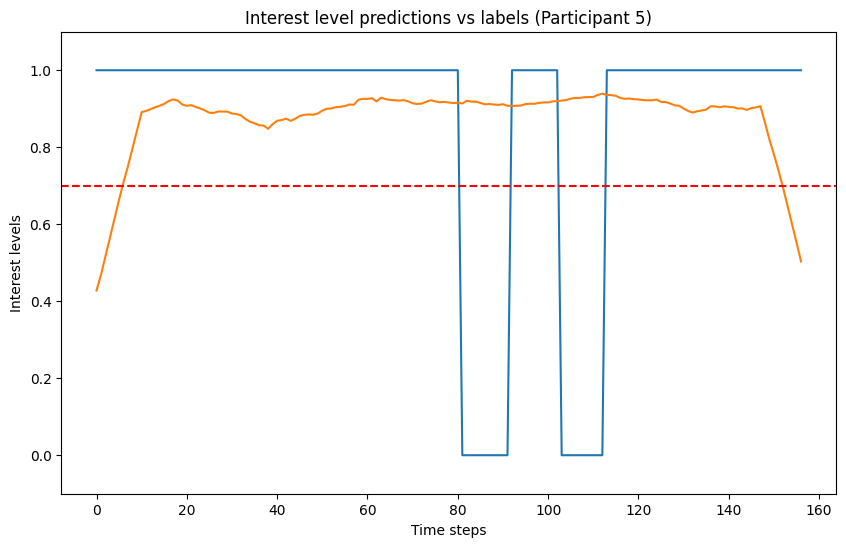

8
              precision    recall  f1-score   support

           0       0.33      0.09      0.14        22
           1       0.88      0.97      0.92       151

    accuracy                           0.86       173
   macro avg       0.61      0.53      0.53       173
weighted avg       0.81      0.86      0.83       173



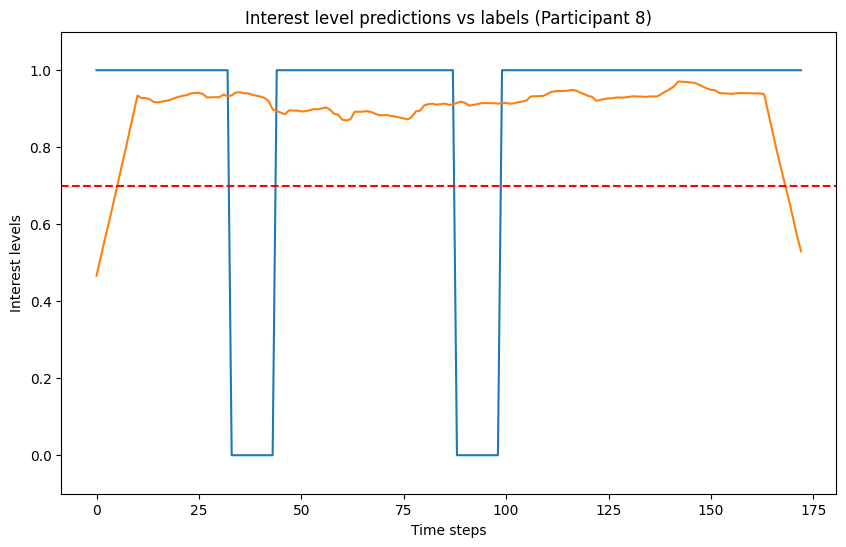

15
              precision    recall  f1-score   support

           0       0.61      0.86      0.72        44
           1       0.97      0.88      0.92       194

    accuracy                           0.87       238
   macro avg       0.79      0.87      0.82       238
weighted avg       0.90      0.87      0.88       238



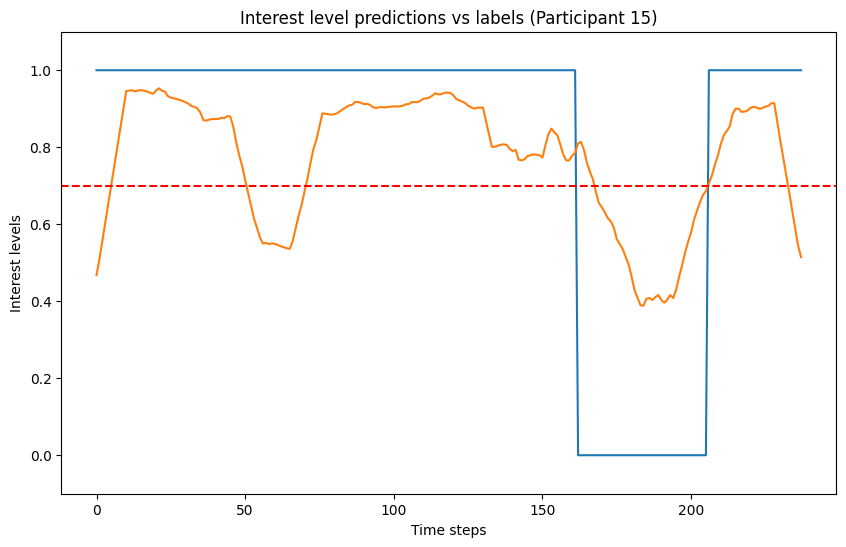

17
              precision    recall  f1-score   support

           0       0.42      0.85      0.57        33
           1       0.95      0.71      0.81       132

    accuracy                           0.74       165
   macro avg       0.69      0.78      0.69       165
weighted avg       0.84      0.74      0.76       165



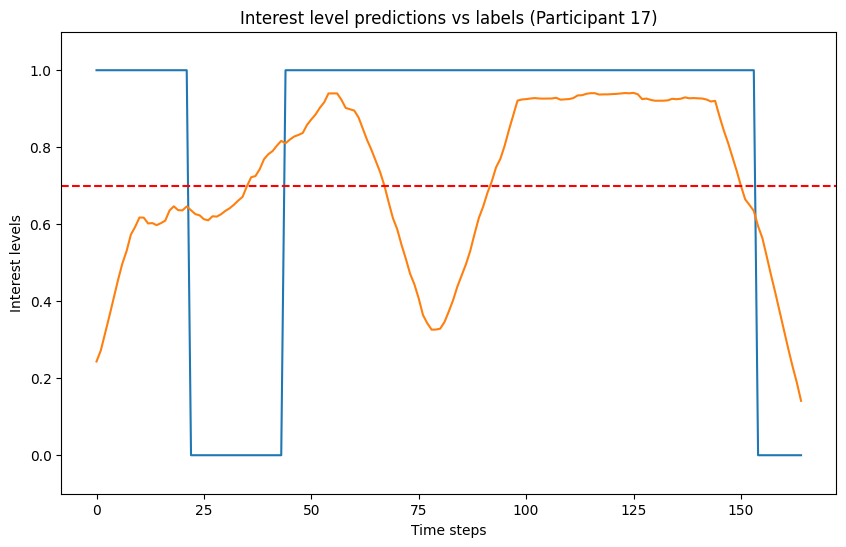

23
              precision    recall  f1-score   support

           0       0.34      0.77      0.47        22
           1       0.97      0.82      0.89       182

    accuracy                           0.81       204
   macro avg       0.65      0.80      0.68       204
weighted avg       0.90      0.81      0.84       204



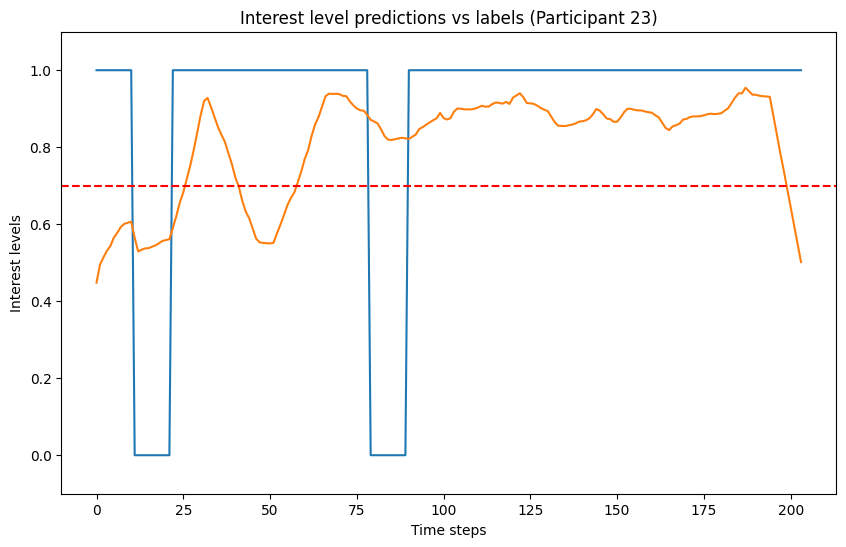

32
              precision    recall  f1-score   support

           0       0.36      0.52      0.43        23
           1       0.93      0.88      0.91       175

    accuracy                           0.84       198
   macro avg       0.65      0.70      0.67       198
weighted avg       0.87      0.84      0.85       198



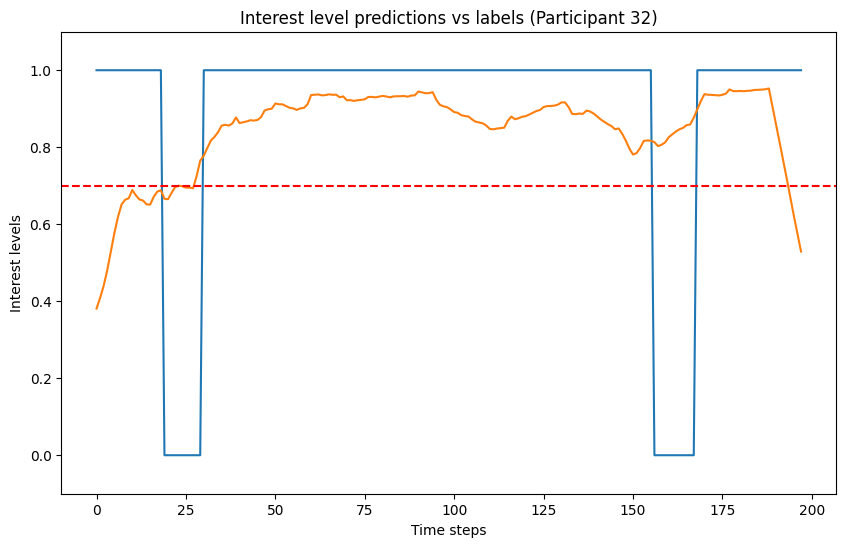

37
              precision    recall  f1-score   support

           0       0.35      0.81      0.49        42
           1       0.89      0.51      0.65       126

    accuracy                           0.58       168
   macro avg       0.62      0.66      0.57       168
weighted avg       0.76      0.58      0.61       168



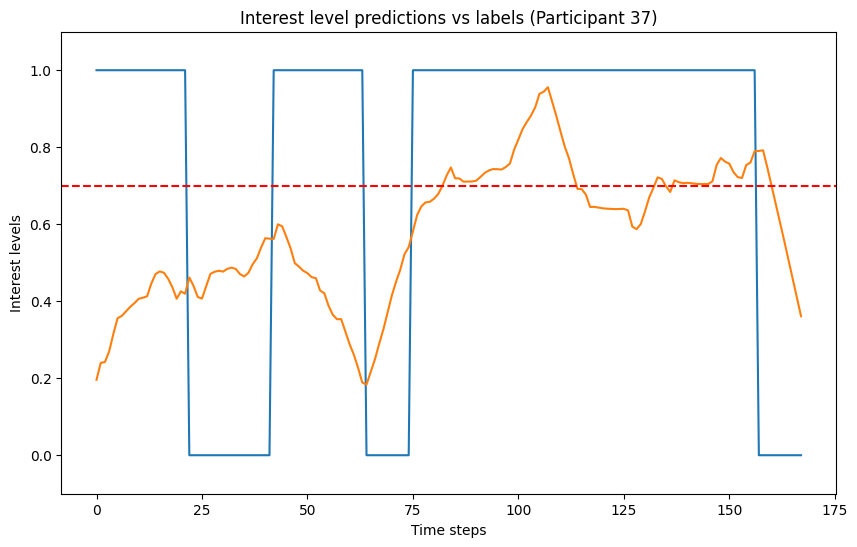

In [16]:
test_indices = [5, 8, 15, 17, 23, 32, 37]
for ind in test_indices:
    temptest = f"finaldata_{250}/{ind}.csv"

    chunked_df = preprocess_and_chunk(temptest, chunk_size)
    otherDF = chunked_df.copy(deep=True)
    otherDF = otherDF.drop(columns=['Label', 'Frame'])
    otherDF = otherDF.fillna(otherDF.median())

    y_pred_proba = svm_clf.predict_proba(otherDF)
    y_pred = svm_clf.predict(otherDF)
    realLabels = chunked_df['Label'].tolist()

    print(f"{ind}\n{classification_report(realLabels, y_pred)}")

    # for x,y in zip(y_pred_proba, y_pred):
    #     print(round(x[1],2),y)

    temp = []
    for x in y_pred_proba:
        temp.append(x[1])
    temp = smooth_data(temp, 20)

    import matplotlib.pyplot as plt

    plt.figure(figsize=(10,6))
    plt.plot(chunked_df.index, chunked_df['Label'])
    plt.plot(range(len(temp)), temp, label='temp')
    plt.axhline(0.7, color='r', linestyle='--', label='Threshold')


    plt.xlabel('Time steps')
    plt.ylabel('Interest levels')
    plt.title(f'Interest level predictions vs labels (Participant {ind})')
    plt.ylim([-0.1, 1.1])  # this ensures that the y-axis is scaled appropriately for binary data
    plt.show()

MODEL PREDICTIONS:
              precision    recall  f1-score   support

           0       0.42      0.85      0.57        33
           1       0.95      0.71      0.81       132

    accuracy                           0.74       165
   macro avg       0.69      0.78      0.69       165
weighted avg       0.84      0.74      0.76       165

LIRIDON PREDICTIONS:
              precision    recall  f1-score   support

           0       0.50      0.67      0.57        33
           1       0.91      0.83      0.87       132

    accuracy                           0.80       165
   macro avg       0.70      0.75      0.72       165
weighted avg       0.83      0.80      0.81       165

ELENA PREDICTIONS:
              precision    recall  f1-score   support

           0       0.33      0.33      0.33        33
           1       0.83      0.83      0.83       132

    accuracy                           0.73       165
   macro avg       0.58      0.58      0.58       165
weighted avg   

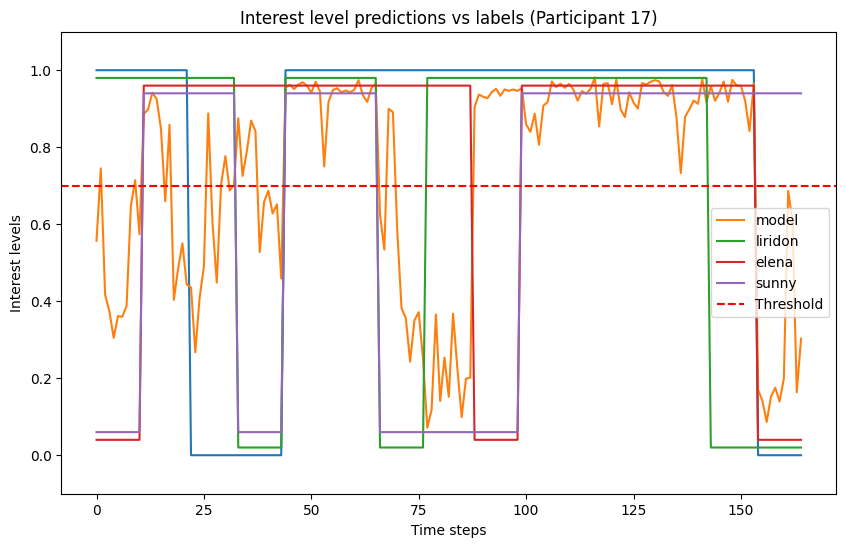

MODEL PREDICTIONS:
              precision    recall  f1-score   support

           0       0.34      0.77      0.47        22
           1       0.97      0.82      0.89       182

    accuracy                           0.81       204
   macro avg       0.65      0.80      0.68       204
weighted avg       0.90      0.81      0.84       204

LIRIDON PREDICTIONS:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.89      1.00      0.94       182

    accuracy                           0.89       204
   macro avg       0.45      0.50      0.47       204
weighted avg       0.80      0.89      0.84       204

ELENA PREDICTIONS:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.88      0.88      0.88       182

    accuracy                           0.79       204
   macro avg       0.44      0.44      0.44       204
weighted avg   

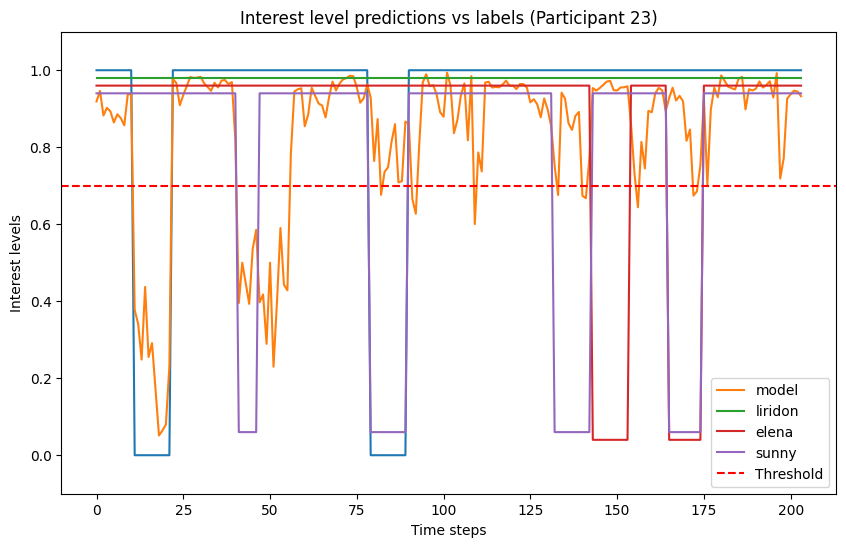

MODEL PREDICTIONS:
              precision    recall  f1-score   support

           0       0.36      0.52      0.43        23
           1       0.93      0.88      0.91       175

    accuracy                           0.84       198
   macro avg       0.65      0.70      0.67       198
weighted avg       0.87      0.84      0.85       198

LIRIDON PREDICTIONS:
              precision    recall  f1-score   support

           0       1.00      0.35      0.52        23
           1       0.92      1.00      0.96       175

    accuracy                           0.92       198
   macro avg       0.96      0.67      0.74       198
weighted avg       0.93      0.92      0.91       198

ELENA PREDICTIONS:
              precision    recall  f1-score   support

           0       0.55      1.00      0.71        23
           1       1.00      0.89      0.94       175

    accuracy                           0.90       198
   macro avg       0.77      0.95      0.83       198
weighted avg   

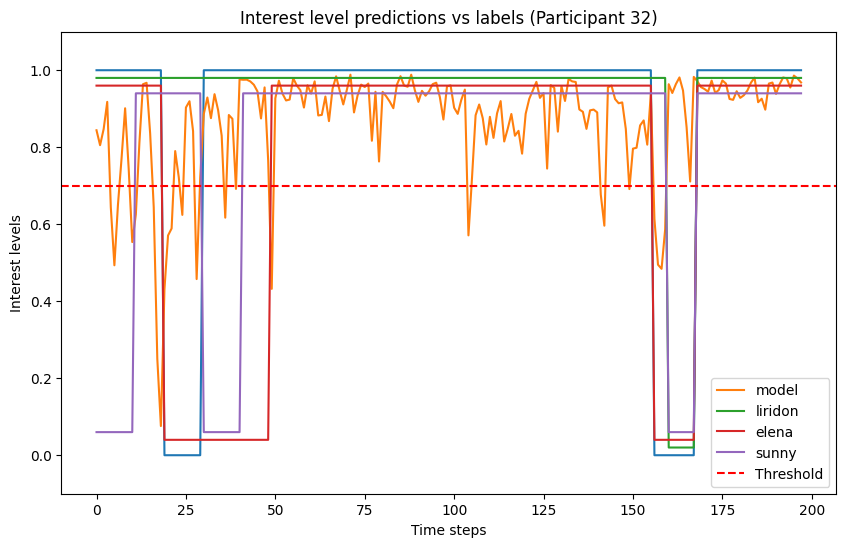

--------------------------- FINAL SCORE ---------------------------
MODEL PREDICTIONS:
              precision    recall  f1-score   support

           0       0.38      0.73      0.50        78
           1       0.95      0.81      0.88       489

    accuracy                           0.80       567
   macro avg       0.67      0.77      0.69       567
weighted avg       0.87      0.80      0.82       567

LIRIDON PREDICTIONS:
              precision    recall  f1-score   support

           0       0.58      0.38      0.46        78
           1       0.91      0.96      0.93       489

    accuracy                           0.88       567
   macro avg       0.74      0.67      0.70       567
weighted avg       0.86      0.88      0.87       567

ELENA PREDICTIONS:
              precision    recall  f1-score   support

           0       0.35      0.44      0.39        78
           1       0.91      0.87      0.89       489

    accuracy                           0.81       567
 

In [26]:
test_indices = [17, 23, 32]
y_pred_agg = []
realLabels_agg = []
liridon_agg = []
elena_agg = []
sunny_agg = []
majority_agg = []
for ind in test_indices:
    temptest = f"human_labels/{ind}.csv"
    
    chunked_df = preprocess_and_chunk(temptest, chunk_size, humanCheck=True)
    otherDF = chunked_df.copy(deep=True)
    liridonLabels = otherDF['liridonLabels'].tolist()
    liridon_agg += liridonLabels
    elenaLabels = otherDF['elenaLabels'].tolist()
    elena_agg += elenaLabels
    sunnyLabels = otherDF['sunnyLabels'].tolist()
    sunny_agg += sunnyLabels

    majorityLabels = [1 if x+y+z >= 2 else 0 for x, y, z in zip(liridonLabels, sunnyLabels, elenaLabels)]
    majority_agg += majorityLabels

    liridonGraph = [0.02 if x == 0 else 0.98 for x in liridonLabels]
    elenaGraph = [0.04 if x == 0 else 0.96 for x in elenaLabels]
    sunnyGraph = [0.06 if x == 0 else 0.94 for x in sunnyLabels]

    otherDF = otherDF.drop(columns=['Label', 'Frame', 'liridonLabels', 'elenaLabels', 'sunnyLabels'])
    otherDF = otherDF.fillna(otherDF.median())

    y_pred_proba = svm_clf.predict_proba(otherDF)
    y_pred = svm_clf.predict(otherDF)
    y_pred_agg += y_pred.tolist()
    realLabels = chunked_df['Label'].tolist()
    realLabels_agg += realLabels

    print(f"MODEL PREDICTIONS:\n{classification_report(realLabels, y_pred)}")
    print(f"LIRIDON PREDICTIONS:\n{classification_report(realLabels, liridonLabels)}")
    print(f"ELENA PREDICTIONS:\n{classification_report(realLabels, elenaLabels)}")
    print(f"SUNNY PREDICTIONS:\n{classification_report(realLabels, sunnyLabels)}")
    print(f"MAJORITY PREDICTIONS:\n{classification_report(realLabels, majorityLabels)}")

    # for x,y in zip(y_pred_proba, y_pred):
    #     print(round(x[1],2),y)

    temp = []
    for x in y_pred_proba:
        temp.append(x[1])
    temp = smooth_data(temp, 1)

    import matplotlib.pyplot as plt

    plt.figure(figsize=(10,6))
    plt.plot(chunked_df.index, chunked_df['Label'])
    plt.plot(range(len(temp)), temp, label='model')
    plt.plot(range(len(liridonGraph)), liridonGraph, label='liridon')
    plt.plot(range(len(elenaGraph)), elenaGraph, label='elena')
    plt.plot(range(len(sunnyGraph)), sunnyGraph, label='sunny')
    plt.axhline(0.7, color='r', linestyle='--', label='Threshold')


    plt.xlabel('Time steps')
    plt.ylabel('Interest levels')
    plt.title(f'Interest level predictions vs labels (Participant {ind})')
    plt.ylim([-0.1, 1.1])  # this ensures that the y-axis is scaled appropriately for binary data
    plt.legend()
    plt.show()

print('--------------------------- FINAL SCORE ---------------------------')
print(f"MODEL PREDICTIONS:\n{classification_report(realLabels_agg, y_pred_agg)}")
print(f"LIRIDON PREDICTIONS:\n{classification_report(realLabels_agg, liridon_agg)}")
print(f"ELENA PREDICTIONS:\n{classification_report(realLabels_agg, elena_agg)}")
print(f"SUNNY PREDICTIONS:\n{classification_report(realLabels_agg, sunny_agg)}")
print(f"MAJORITY PREDICTIONS:\n{classification_report(realLabels_agg, majority_agg)}")

In [25]:
majority_agg = [1 if x+y+z >= 2 else 0 for x, y, z in zip(liridon_agg, sunny_agg, elena_agg)]



(1, 0, 0), total:0
(1, 0, 0), total:0
(1, 0, 0), total:0
(1, 0, 0), total:0
(1, 0, 0), total:0
(1, 0, 0), total:0
(1, 0, 0), total:0
(1, 0, 0), total:0
(1, 0, 0), total:0
(1, 0, 0), total:0
(1, 0, 0), total:0
(1, 1, 1), total:1
(1, 1, 1), total:1
(1, 1, 1), total:1
(1, 1, 1), total:1
(1, 1, 1), total:1
(1, 1, 1), total:1
(1, 1, 1), total:1
(1, 1, 1), total:1
(1, 1, 1), total:1
(1, 1, 1), total:1
(1, 1, 1), total:1
(1, 1, 1), total:1
(1, 1, 1), total:1
(1, 1, 1), total:1
(1, 1, 1), total:1
(1, 1, 1), total:1
(1, 1, 1), total:1
(1, 1, 1), total:1
(1, 1, 1), total:1
(1, 1, 1), total:1
(1, 1, 1), total:1
(1, 1, 1), total:1
(0, 0, 1), total:0
(0, 0, 1), total:0
(0, 0, 1), total:0
(0, 0, 1), total:0
(0, 0, 1), total:0
(0, 0, 1), total:0
(0, 0, 1), total:0
(0, 0, 1), total:0
(0, 0, 1), total:0
(0, 0, 1), total:0
(0, 0, 1), total:0
(1, 1, 1), total:1
(1, 1, 1), total:1
(1, 1, 1), total:1
(1, 1, 1), total:1
(1, 1, 1), total:1
(1, 1, 1), total:1
(1, 1, 1), total:1
(1, 1, 1), total:1
(1, 1, 1), t